# Lab4. Training, Deploying and hosting custom model on SageMaker

In this lab, you will run your training job with SageMaker. You will use your CNN architecture and script that you build at Lab3. 

* **Make sure you change the bucket name None with your S3 bucket name**


In [13]:
bucket = None # custom bucket name such as 'leonkang-datalake-nv' 
prefix = 'anpr'
assert bucket != None

 ## Set up SageMaker environment

* **Plase note that the Tensorflow eager mode will be enabled by below code:**  
 tf.enable_eager_execution()

In [2]:
from PIL import Image
import json
import os
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.contrib.eager.python import tfe
from sagemaker.tensorflow import TensorFlow

tf.enable_eager_execution()

In [3]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

arn:aws:iam::308961792850:role/service-role/AmazonSageMaker-ExecutionRole-20180531T094549
CPU times: user 155 ms, sys: 18.8 ms, total: 174 ms
Wall time: 191 ms


## Upload data to S3

* Upload files to S3
* It may take several minutes **(5 minutes for 10,000 images)**

In [22]:
s3_train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-train')
s3_validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-validation')
s3_train_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-train_annotation')
s3_validation_annotation = 's3://{}/{}/{}'.format(bucket, prefix, 'tf/tf-validation_annotation')

In [23]:
%%time
!aws s3 cp tf/tf-train {s3_train_data} --recursive --include "*1_0.png" --include "*2_0.png" --include "*3_0.png" --include "*4_0.png" --include "*5_0.png" > /dev/null
!aws s3 cp tf/tf-train {s3_train_data} --recursive --include "*6_0.png" --include "*7_0.png" --include "*8_0.png" --include "*9_0.png" --include "*0_0.png" > /dev/null
!aws s3 cp tf/tf-train {s3_train_data} --recursive --include "*1_1.png" --include "*2_1.png" --include "*3_1.png" --include "*4_1.png" --include "*5_1.png" > /dev/null
!aws s3 cp tf/tf-train {s3_train_data} --recursive --include "*6_1.png" --include "*7_1.png" --include "*8_1.png" --include "*9_1.png" --include "*0_1.png" > /dev/null
!aws s3 cp tf/tf-validation {s3_validation_data} --recursive > /dev/null
!aws s3 cp tf/tf-train_annotation {s3_train_annotation} --recursive > /dev/null
!aws s3 cp tf/tf-validation_annotation {s3_validation_annotation} --recursive > /dev/null

CPU times: user 4.05 s, sys: 586 ms, total: 4.63 s
Wall time: 4min 22s


* Check upload results 

In [25]:
!aws s3 ls {s3_train_data}/ |wc -l
!aws s3 ls {s3_validation_data}/ |wc -l
!aws s3 ls {s3_train_annotation}/ |wc -l
!aws s3 ls {s3_validation_annotation}/ |wc -l

8000
2000
8000
2000


In [26]:
s3_output_location = 's3://{}/{}/tf-output'.format(bucket, prefix)

## Check data channels

Training data will be copied from S3 to Tensorflow container.  
Refer to the below directory paths.

### Test and validation data directories
1) In this notebook
- train images: './tf/tf-train'
- train annotations: './tf/tf-train_annotations'
- validation images: './tf/tf-validation'
- validation annotations: './tf/tf-validation_annotations'

2) S3
- train images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train'
- train annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation'
- validation images: 's3://leonkang-datalake-seoul/anpr/tf/tf-train_annotations'
- validation annotations: 's3://leonkang-datalake-seoul/anpr/tf/tf-validation_annotations'

**3) Training container (Tensorflow container)**
- **train images: '/opt/ml/input/data/train/'**
- **train annotations: '/opt/ml/input/data/train_annotation/'**
- **validation images: '/opt/ml/input/data/validation/'**
- **validation annotations: '/opt/ml/input/data/validation_annotation/'**

In [28]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='image/png', s3_data_type='S3Prefix')
validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='image/png', s3_data_type='S3Prefix')
train_annotation = sagemaker.session.s3_input(s3_train_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')
validation_annotation = sagemaker.session.s3_input(s3_validation_annotation, distribution='FullyReplicated', 
                             content_type='application/json', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data, 
                 'train_annotation': train_annotation, 'validation_annotation':validation_annotation}


* Refer to API specs of SDK site
    * https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst
    * https://sagemaker.readthedocs.io/en/latest/using_tf.html
* Refer to the API document 
    * https://sagemaker.readthedocs.io/en/stable/sagemaker.tensorflow.html  
   (Note that checkpoint_path, training_steps, evaluation_steps, requirements_file args are not permitted when using Script Mode)

## Check the code of 'cnn_ocr.py' for entry_point
* Thins file will be passed as entry_point when defining Tensorflow Estimator
* Notice that **model() function and get_data_pair() function are exactly same** as Lab3
* In the main function, input data are loaded from local directory **'/opt/ml/input/data/{...channel...}'**
* In the main function, output model will be stored in **'/opt/ml/model'** directory
* Hperparameters are parsed from argparse.ArgumentParser() as they will **be passed as arguments of the python run command line script**.

In [79]:
#!cat cnn_ocr.py

```python
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.layers import concatenate
import os
import argparse

import json
from PIL import Image

import keras.backend as K
K.set_image_data_format('channels_last')
import tensorflow as tf

from tensorflow.contrib.eager.python import tfe

tf.enable_eager_execution()
tf.set_random_seed(0)

NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '무', 
       '버', '서', '어', '저', '처', '커', '터', '퍼', '보', '소', '오', '조', '초', '코', '토', '포', '부', '수', '우', '주', '추', '쿠', '투', '푸', '후', 
       '그', '느', '드', '르', '므', '브', '스', '으', '즈', '츠', '크', '트', '프', '흐',
       '바', '사', '아', '자', '차', '카', '타', '파', '하', '허', '호']
SPACE=[' ']
JOIN =NUMS + CHARS + SPACE
n_chr = len(JOIN)

def parse_args():
    
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=100)
    parser.add_argument('--batch_size', type=int, default=64)
    parser.add_argument('--learning_rate', type=float, default=0.001)
    parser.add_argument('--verbose', type=int, default=1)
    
    # data directories
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--test', type=str, default=os.environ.get('SM_CHANNEL_TEST'))
    
    # model directory: we will use the default set by SageMaker, /opt/ml/model
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    
    return parser.parse_known_args()

def get_data_pair(train_dir, annotation_dir):
    t_jsns = os.listdir(annotation_dir)
    flg_first = True
    for i in t_jsns:
        ext = i.split('.')[1]
        if ext == 'json':
            with open(annotation_dir + i, "r") as jfile:
                jdata = json.load(jfile)
                # read image
                img=Image.open(train_dir + jdata['file']) 
                img = img.resize((128, 64))
                imgs = img if flg_first else np.append(imgs, img)
                # read license plate numbers
                n_ = np.array(jdata['nums'])
                Y_t = np.zeros((n_chr, 7))
                Y_t[n_, np.arange(7)] = 1
                Y_ = Y_t if (flg_first) else np.append(Y_, Y_t)
                flg_first = False
    digits= np.split(Y_.reshape([-1,7]), 7, axis=1)
    return imgs.reshape([-1, 128, 64, 1])/255., [i.reshape([-1,81]) for i in digits]

def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input)

    # CONV0 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(48, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool0')(X)

    # CONV1 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((1, 2), strides = (2, 2), name='max_pool1')(X)

    # CONV2 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)

    #----------------------------------------------------------
    d1 = tf.keras.layers.Dense(81, activation='softmax', name='d1')(X)
    d2 = tf.keras.layers.Dense(81, activation='softmax', name='d2')(X)
    d3 = tf.keras.layers.Dense(81, activation='softmax', name='d3')(X)
    d4 = tf.keras.layers.Dense(81, activation='softmax', name='d4')(X)
    d5 = tf.keras.layers.Dense(81, activation='softmax', name='d5')(X)
    d6 = tf.keras.layers.Dense(81, activation='softmax', name='d6')(X)
    d7 = tf.keras.layers.Dense(81, activation='softmax', name='d7')(X)
    
    model = tf.keras.Model(inputs = X_input, 
                  outputs = [d1,d2,d3,d4,d5,d6,d7],
                  name='CNN_ANPR')

    return model

if __name__ == "__main__":

    args, _ = parse_args()
    print('args test: learning_rate = {}, batch_size = {}, epochs = {}'.format(args.learning_rate, args.batch_size, args.epochs))
    
    # change the path to use '/opt/ml/input/data/{channel}/...'
    t_imgs, t_annotations = get_data_pair('/opt/ml/input/data/train/', '/opt/ml/input/data/train_annotation/')
    v_imgs, v_annotations = get_data_pair('/opt/ml/input/data/validation/', '/opt/ml/input/data/validation_annotation/')
    
    device = '/gpu:0' 
    print(device)
    
    with tf.device(device):
        input_shape = (128,64,1)
        model_k = model(input_shape)
        
        # use hyperparameters ex) args.learning_rate
        model_k.compile(optimizer=tf.train.AdamOptimizer(args.learning_rate), 
                loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy','categorical_crossentropy',
                      'categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
                metrics = ["accuracy"])
        
        # use hyperparameters ex) args.epochs, args.batch_size, etc.
        model_k.fit(t_imgs, [i.reshape([-1,81]) for i in t_annotations], 
            validation_data=(v_imgs, [i.reshape([-1,81]) for i in v_annotations]), 
            epochs=args.epochs, batch_size=args.batch_size, verbose=args.verbose)
        
        scores = model_k.evaluate(v_imgs, [i for i in v_annotations], batch_size=args.batch_size, verbose=1, sample_weight=None)
        print("scores: ", scores)
        
        # save checkpoint for locally loading in notebook
        saver = tfe.Saver(model_k.variables)
        saver.save(args.model_dir + '/weights.ckpt')
        
        # create a separate SavedModel for deployment to a SageMaker endpoint with TensorFlow Serving
        tf.contrib.saved_model.save_keras_model(model_k, args.model_dir)
            
```

## Run training job
* **This time, we will run 30 epochs. (It may take laround 15 minutes)**
* Note that we use p3.2xlarge instance, which will shorten our training time with GPU. 
* To see the detailed message of training job, set the verobose to 1(true).

In [60]:
model_dir = '/opt/ml/model'
train_instance_type='ml.p3.2xlarge'
hyperparameters = {'epochs': 30, 
                   'batch_size': 128,
                   'learning_rate': 0.001,
                   'verbose': 0}

In [61]:
ocr_estimator = TensorFlow(entry_point='cnn_ocr.py',
                             role=role,
                             model_dir=model_dir,
                             hyperparameters=hyperparameters,
                             train_instance_count=2,
                             train_instance_type=train_instance_type,
                             distributions={'parameter_server': {'enabled': True}},
#                              distributions={
#                                   'mpi': {
#                                       'enabled': True,
#                                       'processes_per_host': 8,
#                                       'custom_mpi_options': '--NCCL_DEBUG INFO'
#                                   }
#                              }),
                             framework_version='1.12', 
                             py_version='py3')

In [63]:
%%time
ocr_estimator.fit(data_channels, logs=True)

INFO:sagemaker:Creating training-job with name: sagemaker-tensorflow-scriptmode-2019-06-01-06-48-35-871


2019-06-01 06:48:36 Starting - Starting the training job...
2019-06-01 06:48:39 Starting - Launching requested ML instances......
2019-06-01 06:49:47 Starting - Preparing the instances for training......
2019-06-01 06:51:01 Downloading - Downloading input data..............
2019-06-01 06:53:20,028 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-06-01 06:53:20,057 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-06-01 06:53:20,057 sagemaker_tensorflow_container.training INFO     Launching parameter server process
2019-06-01 06:53:20,057 sagemaker_tensorflow_container.training INFO     Running distributed training job with parameter servers
2019-06-01 06:53:20,187 sagemaker_tensorflow_container.training INFO     Launching worker process
2019-06-01 06:53:20,577 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {
        "sagem

* Check the model name that training job just created
* Check the model file that training job just created

In [64]:
print(ocr_estimator.output_path)
print(ocr_estimator.model_data)

!aws s3 ls {ocr_estimator.model_data}

s3://sagemaker-us-east-1-308961792850/
s3://sagemaker-us-east-1-308961792850/sagemaker-tensorflow-scriptmode-2019-06-01-06-48-35-871/output/model.tar.gz
2019-06-01 06:59:20   75742254 model.tar.gz


## Test data

* Prepare character list and test images

In [65]:
import numpy as np

In [66]:
NUMS =['1', '2', '3', '4', '5', '6', '7', '8', '9', '0']
CHARS=['가', '나', '다', '라', '마', '거', '너', '더', '러', '머', '고', '노', '도', '로', '모', '구', '누', '두', '루', '무', 
       '버', '서', '어', '저', '처', '커', '터', '퍼', '보', '소', '오', '조', '초', '코', '토', '포', '부', '수', '우', '주', '추', '쿠', '투', '푸', '후', 
       '그', '느', '드', '르', '므', '브', '스', '으', '즈', '츠', '크', '트', '프', '흐',
       '바', '사', '아', '자', '차', '카', '타', '파', '하', '허', '호']
SPACE=[' ']
JOIN =NUMS + CHARS + SPACE
n_chr = len(JOIN)

In [67]:
test_imgs = os.listdir('tf/tf-validation')

## Test the trainned model in local

* Copy trainned model from S3 to ./model folder

In [68]:
#!rm -Rf model
!aws s3 cp {ocr_estimator.model_data} ./model/model.tar.gz --region {sess.boto_region_name}

download: s3://sagemaker-us-east-1-308961792850/sagemaker-tensorflow-scriptmode-2019-06-01-06-48-35-871/output/model.tar.gz to model/model.tar.gz


* Extract the model file and see the components

In [69]:
!tar -xvzf ./model/model.tar.gz -C ./model

weights.ckpt.index
weights.ckpt.data-00000-of-00001
checkpoint
1559372344/
1559372344/assets/
1559372344/assets/saved_model.json
1559372344/variables/
1559372344/variables/variables.index
1559372344/variables/variables.data-00000-of-00001
1559372344/variables/checkpoint
1559372344/saved_model.pb
weights.ckpt.data-00000-of-00001
checkpoint
1559372346/
1559372346/saved_model.pb
1559372346/variables/
1559372346/variables/variables.data-00000-of-00001
1559372346/variables/checkpoint
1559372346/variables/variables.index
1559372346/assets/
1559372346/assets/saved_model.json
weights.ckpt.index


* Define model architecture locally (same as Lab3)

In [70]:
import matplotlib.pyplot as plt
def model(input_shape):
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = tf.keras.Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = tf.keras.layers.ZeroPadding2D((2, 2))(X_input)

    # CONV0 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(48, (5, 5), strides = (1, 1), name = 'conv0')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn0')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool0')(X)

    # CONV1 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv1')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn1')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((1, 2), strides = (2, 2), name='max_pool1')(X)

    # CONV2 -> BN -> RELU -> MAXPOOL applied to X
    X = tf.keras.layers.Conv2D(64, (5, 5), strides = (1, 1), name = 'conv2')(X)
    X = tf.keras.layers.BatchNormalization(axis = 3, name = 'bn2')(X)
    X = tf.keras.layers.Activation('relu')(X)
    X = tf.keras.layers.MaxPooling2D((2, 2), strides = (2, 2), name='max_pool2')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = tf.keras.layers.Flatten()(X)
    #----------------------------------------------------------
    d1 = tf.keras.layers.Dense(81, activation='softmax', name='d1')(X)
    d2 = tf.keras.layers.Dense(81, activation='softmax', name='d2')(X)
    d3 = tf.keras.layers.Dense(81, activation='softmax', name='d3')(X)
    d4 = tf.keras.layers.Dense(81, activation='softmax', name='d4')(X)
    d5 = tf.keras.layers.Dense(81, activation='softmax', name='d5')(X)
    d6 = tf.keras.layers.Dense(81, activation='softmax', name='d6')(X)
    d7 = tf.keras.layers.Dense(81, activation='softmax', name='d7')(X)
    
    model = tf.keras.Model(inputs = X_input, 
                  outputs = [d1,d2,d3,d4,d5,d6,d7],
                  name='CNN_ANPR')

    return model

* Read and retore model from downloaded checkpoint

In [71]:
tf.keras.backend.clear_session()
device = '/cpu:0' 

with tf.device(device):    
    local_model = model((128,64,1))
    saver = tfe.Saver(local_model.variables)
    saver.restore('model/weights.ckpt')

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from model/weights.ckpt


INFO:tensorflow:Restoring parameters from model/weights.ckpt


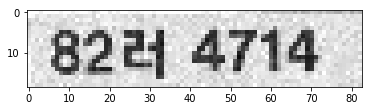

['8', '4', '러', '4', '7', '1', '4']


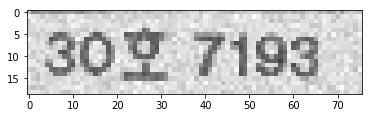

['3', '0', '호', '7', '3', '9', '3']


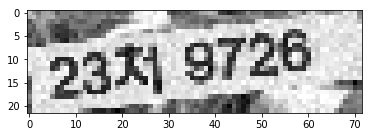

['2', '3', '저', '9', '7', '2', '6']


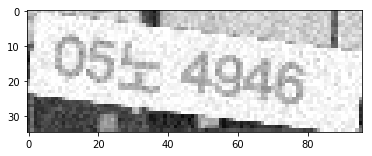

['0', '5', '느', '4', '9', '4', '6']


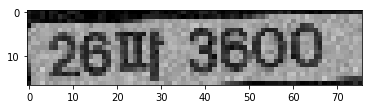

['2', '6', '파', '3', '6', '0', '0']


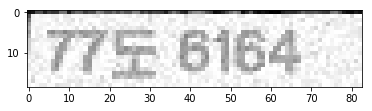

['7', '7', '도', '6', '1', '4', '4']


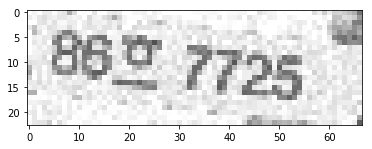

['8', '6', '호', '7', '7', '2', '5']


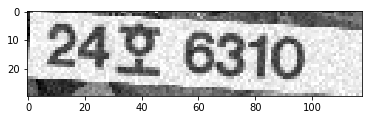

['2', '4', '호', '6', '3', '1', '0']


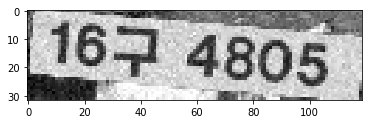

['1', '6', '푸', '4', '0', '0', '8']


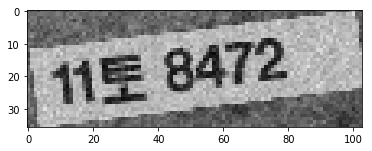

['1', '1', '르', '8', '7', '7', '2']


In [72]:
for i in range(10):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((128,64)))
    prediction = local_model.predict(val_img_np.reshape([1,128,64,1])/255.)
    plt.imshow(val_img)
    plt.show()
    digits = [JOIN[np.argmax(prediction[0][0])], 
              JOIN[np.argmax(prediction[1][0])], 
              JOIN[np.argmax(prediction[2][0])], 
              JOIN[np.argmax(prediction[3][0])], 
              JOIN[np.argmax(prediction[4][0])], 
              JOIN[np.argmax(prediction[5][0])], 
              JOIN[np.argmax(prediction[6][0])]]
    print(digits)

* You may utilize above code to build your own inference environment
* You can find that the accuracy of our model is increased
* We may further refine our model in the following ways:
    * Adding more training images and more epochs
    * Adding real world license plate images
    * Changing an architecture to another structure (ex: CNN + LSTM)
    * Combining Object detection and this OCR model into one CNN architecture (Usually, end-to-end approach needs more training data)

## Deploy the model and inference Test

* Now, let's deploy our model into SageMaker's inference hosting environment 

In [74]:
predictor = ocr_estimator.deploy(initial_instance_count=1,
                                 instance_type='ml.m4.xlarge',
                                 accelerator_type='ml.eia1.medium')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-scriptmode-2019-06-01-06-48-35-871
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-scriptmode-2019-06-01-06-48-35-871


----------------------------------------------------------------------------------------!

* Check the result of deploy

In [75]:
predictor.endpoint

'sagemaker-tensorflow-scriptmode-2019-06-01-06-48-35-871'

* Check the prediction of 10 sample pairs of images

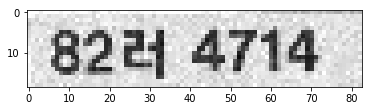

0
['8', '4', '러', '4', '7', '1', '4']


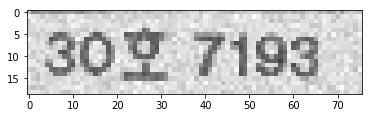

1
['3', '0', '호', '7', '3', '9', '3']


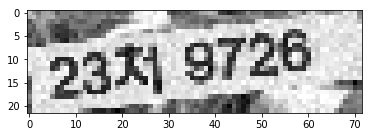

2
['2', '3', '저', '9', '7', '2', '6']


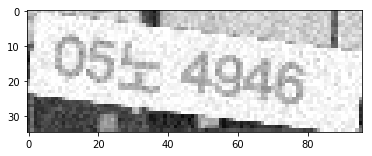

3
['0', '5', '느', '4', '9', '4', '6']


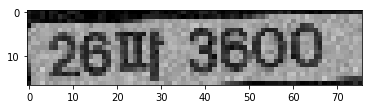

4
['2', '6', '파', '3', '6', '0', '0']


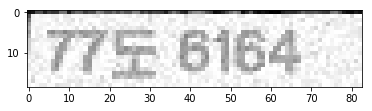

5
['7', '7', '도', '6', '1', '4', '4']


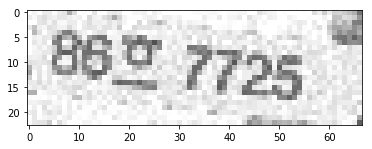

6
['8', '6', '호', '7', '7', '2', '5']


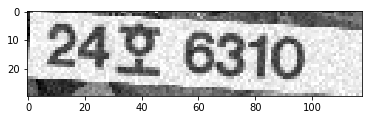

7
['2', '4', '호', '6', '3', '1', '0']


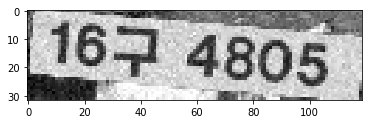

8
['1', '6', '푸', '4', '0', '0', '8']


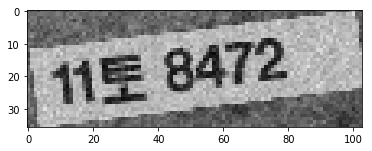

9
['1', '1', '르', '8', '7', '7', '2']


In [76]:
for i in range(10):
    val_img = Image.open('tf/tf-validation/' + test_imgs[i])
    val_img_np = np.array(val_img.resize((128,64)))
    input = {
      'instances': val_img_np.reshape([1,128,64,1])/255.
    }
    prediction = predictor.predict(input)
    plt.imshow(val_img)
    plt.show()
    print(i)
    digits = [JOIN[np.argmax(prediction['predictions'][0]['d1'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d2'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d3'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d4'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d5'])],  
              JOIN[np.argmax(prediction['predictions'][0]['d6'])], 
              JOIN[np.argmax(prediction['predictions'][0]['d7'])]]
    print(digits)

## Endpoint API test

* You may invoke SageMaker endpoint from business application as below:

In [77]:
import boto3
from sagemaker.predictor import json_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON
runtime = boto3.Session().client('runtime.sagemaker')
tf_endpoint = predictor.endpoint

In [78]:
api_predictor = RealTimePredictor(endpoint=tf_endpoint, sagemaker_session=sess, serializer=json_serializer,
                                content_type=CONTENT_TYPE_JSON, accept=CONTENT_TYPE_CSV)
api_response = json.loads(api_predictor.predict(input))
print(JOIN[np.argmax(api_response['predictions'][0]['d1'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d2'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d3'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d4'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d5'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d6'])] +
      JOIN[np.argmax(api_response['predictions'][0]['d7'])] )

11르8772


## Delete Endpoint

In [103]:
sagemaker.Session().delete_endpoint(predictor.endpoint)

INFO:sagemaker:Deleting endpoint with name: sagemaker-tensorflow-scriptmode-2019-03-09-00-23-00-877


## Next step
**Delete resources**(Any endpoints, Notebook instance, and S3 bucket)